# Testing grounds

In [1]:
import functions as f #self-defined functions in functions.py
import kwant
import tinyarray as tiny
import numpy as np 
from numpy import linalg as LA
import scipy.sparse.linalg as sla
from types import SimpleNamespace
import holoviews as hv
from holoviews import opts
from matplotlib import pyplot as plt
hv.extension('matplotlib', logo=False) #BOKEH DOESNT SUPPORT LATEX IN LABELS
# hv.extension('bokeh', logo=False)
hv.output(fig='svg')
import time

s_0 = np.identity(2)
s_z = np.array([[1, 0], [0, -1]])
s_x = np.array([[0, 1], [1, 0]])
s_y = np.array([[0, -1j], [1j, 0]])
# pauli = [sx,sy,sz] #pauli = {'x':sx, 'y':sy, 'z':sz} #as dictionary

#define the Pauli matrices 
pauli = SimpleNamespace(s0=np.array([[1., 0.], [0., 1.]]),
                        sx=np.array([[0., 1.], [1., 0.]]),
                        sy=np.array([[0., -1j], [1j, 0.]]),
                        sz=np.array([[1., 0.], [0., -1.]]))

pauli.s0s0 = tiny.array(np.kron(pauli.s0, pauli.s0)) # I(4)
pauli.s0sx = tiny.array(np.kron(pauli.s0, pauli.sx)) # \sigma_x
pauli.s0sy = tiny.array(np.kron(pauli.s0, pauli.sy)) # \sigma_y
pauli.s0sz = tiny.array(np.kron(pauli.s0, pauli.sz)) # \sigma_z
pauli.sxs0 = tiny.array(np.kron(pauli.sx, pauli.s0)) # \tau_x
pauli.sys0 = tiny.array(np.kron(pauli.sy, pauli.s0)) # \tau_y
pauli.szs0 = tiny.array(np.kron(pauli.sz, pauli.s0)) # \tau_z

C:\ProgramData\Anaconda3\envs\lps\lib\site-packages\kwant\solvers\default.py:18: RuntimeWarning: MUMPS is not available, SciPy built-in solver will be used as a fallback. Performance can be very poor in this case.
  "Performance can be very poor in this case.", RuntimeWarning)


In [2]:
#define a Boolean function to shape your system
radius = 12
def disk(position): 
    x,y = position
    return x**2 + y**2 < radius**2

def magn_texture(position,azi_winding, radi_winding):
    x,y = position
    theta = np.arctan2(x,y)
    q = azi_winding
    p = radi_winding
    R = radius
    r = np.sqrt(x**2 + y**2)
    B = [np.sin(np.pi*p*(r/R))*np.cos(q*theta), np.sin(np.pi*p*(r/R))*np.sin(q*theta), np.cos(np.pi*p*(r/R))]
    return B

def onsite(site, t, mu, j, azi_winding, radi_winding, delta): #define a function to determine the onsite energy term of the Hamiltonian
    position = site.pos #site is a class! Apart from real space position contains the type of atom (to which family it belongs, how many orbitals etc)
#     B = magn_texture(position,azi_winding,radi_winding) #calculate direction of magnetic field at position (x,y)
#     skyrmion_interaction = j*(B[0]*pauli.s0sx + B[1]*pauli.s0sy + B[2]*pauli.s0sz)
    return 4*t*pauli.szs0 - mu*pauli.szs0 + delta*pauli.sxs0 + j*pauli.s0sz
    
def hopping(position1,position2,t): #define the hopping terms in your system
    return -t*pauli.szs0

sys = kwant.Builder() #initialize your system
sqlat = kwant.lattice.square()

sys[sqlat.shape(disk,(0,0))]= onsite
sys[sqlat.neighbors()]= hopping

sys= sys.finalized()
# system_plot = kwant.plot(sys)

Hamiltonian size = 2068x2068 
Solving eigenvalues took 1.042s


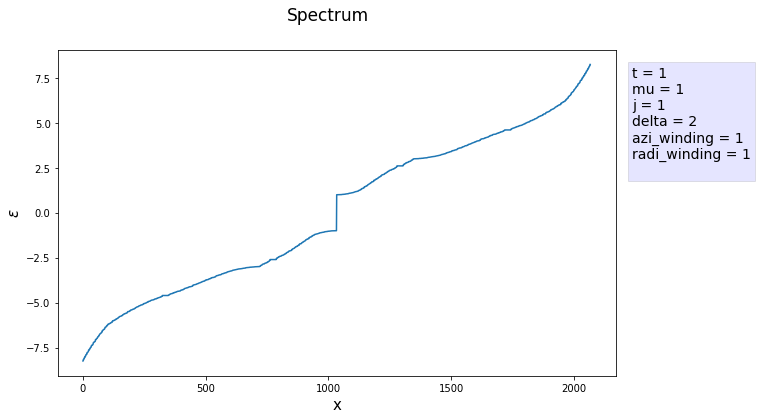

In [24]:
params = dict(t=1, mu=1, j=1, delta=2, azi_winding=1, radi_winding=1)
hoi = f.get_spectrum(sys, params, timing=1, plot=True)

Hamiltonian size = 1748x1748 
Solving 24 times took 21.461s


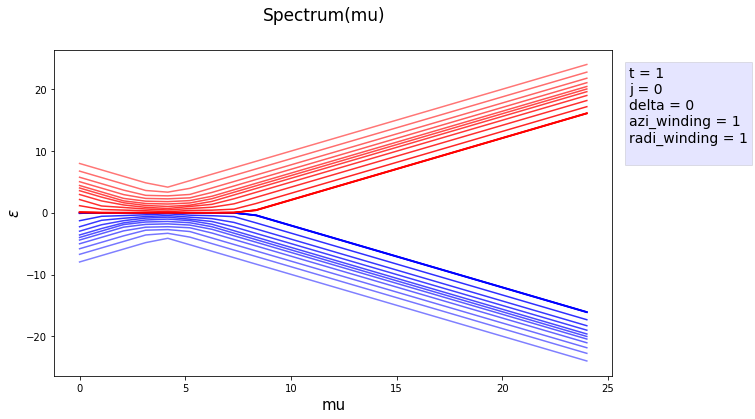

In [3]:
params = dict(t=1, mu=1, j=0, delta=0, azi_winding=1, radi_winding=1)
values = np.linspace(0,24,24)
variable='mu'
spec = f.track_spectrum(sys, params, variable = variable, values = values, bulk_n=10, gap_n=4, timing=1, plot=True)

In [4]:
# hv.extension('bokeh', logo=False) #BOKEH DOESNT SUPPORT LATEX IN LABELS
N_eVal = len(spec[0])
group='Spectrum'
param_str = dict(mu='μ', t='t', prob_dens='$|\psi|^2$', prob_amp='$|\psi|$', E='$\epsilon$', j='J', delta='$\Delta$', \
                            azi_winding = 'q', radi_winding='p')
param_text =''
pars_temp = params.copy()
pars_temp.pop(variable);
for key in pars_temp:
    param_text = param_text + '{} = {}\n'.format(param_str[key], pars_temp[key]) 
    
dims = {'mu':'μ', 'ampli':'$|\psi|^2$', 'x':'$x$', 'E':'$\epsilon$'} #dictionary for dimensions used in plotting
style = SimpleNamespace(color='red', alpha = 0.7)
neg_spec = hv.Overlay([hv.Path((values,spec[:,i]), kdims=[param_str[variable],dims['E']], label='Spectrum({})'.format(variable)).opts(color='blue', alpha=0.5+i/N_eVal) for i in range(N_eVal//2)])
pos_spec = hv.Overlay([hv.Path((values,spec[:,i]), kdims=[param_str[variable],dims['E']], label='Spectrum({})'.format(variable)).opts(color=style.color, alpha=1.5-i/N_eVal) for i in range(N_eVal//2, N_eVal)])
spec_track = neg_spec*pos_spec*hv.Text(1.05*max(values),0,param_text, halign='left', valign='center')
spec_track

:Overlay
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.I     :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.II    :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.III   :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.IV    :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.V     :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.VI    :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.VII   :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.VIII  :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.IX    :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.X     :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.XI    :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.XII   :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.XIII  :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.XIV   :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.XV    :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.XVI   :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.XVII  :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.XVIII :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.XIX   :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.XX    :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.XXI   :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.XXII  :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.XXIII :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.XXIV  :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.XXV   :Path   [μ,$\epsilon$]
   .Path.Spectrum_left_parenthesis_mu_right_parenthesis.XXVI  :Path   [μ,$\epsilon$]
   .Text.I                                                    :Text   [x,y]

In [5]:
hv.save(spec_track, 'fig\spectrum_{}.svg'.format(variable))

In [16]:
spec[0]

array([-7.96114511, -6.72710983, -5.82310065, -5.0189587 , -4.4166743 ,
       -4.        , -3.59854276, -2.98528317, -2.26520933, -1.29440109,
       -0.09825955, -0.09825955, -0.03885489, -0.03885489,  0.03885489,
        0.03885489,  0.09825955,  0.09825955,  1.13972852,  2.13136487,
        2.94759605,  3.56371199,  4.        ,  4.40145724,  5.01471683,
        5.73479067,  6.72305494,  7.96114511])

In [17]:
eVal = LA.eigvalsh(ham)

In [66]:

# def smt(par, var=None):
#     if not isinstance(var, str):
#         print('var is not a string')
#     try:
#         iter(par)
#     except TypeError:
#         print('par is not iterable')
#         return
#     print('hoi')
    
# smt([], var='variable')


In [56]:
for key in param_str:
    print(key)

TypeError: 'types.SimpleNamespace' object is not iterable

In [61]:
chart = [[site.pos[0],site.pos[1]] for site in sys.sites]

In [76]:
sites = sys.sites

In [92]:
for site in sites[:1]:
    x,y = (site.pos[0],site.pos[1])

In [104]:
x = [site.pos[0] for site in sites]
y = [site.pos[1] for site in sites]

In [120]:
prob_dens = np.abs(eVec[::4])**2
hv.Image((x,y,prob_dens),datatype=['grid'])

DataError: Key dimension values and value array z shapes do not match. Expected shape (305, 305), actual shape: (305, 1220)

GridInterface expects gridded data, for more information on supported datatypes see http://holoviews.org/user_guide/Gridded_Datasets.html

In [156]:
prob_dens =np.abs(eVec[0])**2
u_up = prob_dens[2::4]

C:\ProgramData\Anaconda3\envs\lps\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: The plotted data contains 1.89% of values overflowing upper limit 0.00711652 
  """Entry point for launching an IPython kernel.


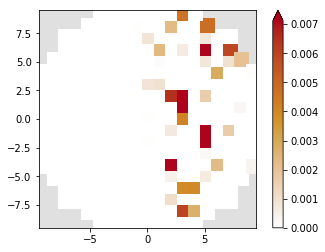

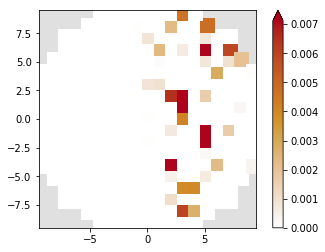

In [157]:
kwant.plotter.map(sys,u_up)